In [ ]:
import pandas as pd

# Load the uploaded Excel file to examine its structure
file_path = 'PsyTAR_Dataset.xlsx'
data = pd.ExcelFile(file_path)

# Display sheet names to understand the file structure
data.sheet_names


['License',
 'read_me',
 'Sample',
 'Sentence_Labeling',
 'ADR_Identified',
 'ADR_Mapped',
 'WD_Identified',
 'Withdraw_Mapped ',
 'SSI_Identified',
 'SSI_Mapped',
 'DI_Identified',
 'DI_Mapped']

In [ ]:
# Preview some potentially relevant sheets to find columns for "text" and "label"
sheet_previews = {sheet: data.parse(sheet).head() for sheet in ['Sample', 'Sentence_Labeling', 'ADR_Identified']}
sheet_previews


{'Sample':    index  comment_index  comment_id    drug_id  rating  \
 0      1            372           1  lexapro.1       1   
 1      2              4           2  lexapro.2       1   
 2      3            419           3  lexapro.3       1   
 3      4           1305           4  lexapro.4       1   
 4      5            909           5  lexapro.5       1   
 
                             disorder  \
 0             depression and anxiety   
 1                         depression   
 2                         depression   
 3  severe gad, minor depression, etc   
 4                depression, anxiety   
 
                                          side-effect  \
 0  extreme weight gain, short-term memory loss, h...   
 1  COMPLETELY DESTROYED SEXUALLY FUNCTIONING - EV...   
 2  Nausea, Blurred Vision, 3 to 5 hours sleep, Su...   
 3  Plenty! First 10 days were HORRIBLE, like a lo...   
 4  Chronic cough, weight gain, no sexual interest...   
 
                                          

In [ ]:
# Install necessary libraries
# !pip install transformers pandas torch openpyxl

import pandas as pd
from transformers import pipeline
from google.colab import files

# Define file names for datasets
PSY_TAR_FILE_NAME = 'PsyTAR_dataset.xlsx'

# Load Hugging Face pipeline using a smaller model for efficiency
validation_pipeline = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Function to load the data from an Excel file
def load_data():
    print("Please upload your Excel file:")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded.")
        return None

    file_name = next(iter(uploaded))
    xls = pd.ExcelFile(file_name)

    # Clean and strip sheet names to remove unwanted characters
    clean_sheet_names = {sheet: sheet.strip() for sheet in xls.sheet_names}
    print("Available sheets:", clean_sheet_names.values())

    desired_sheets = ['ADR_Mapped', 'Withdraw_Mapped', 'SSI_Mapped', 'DI_Mapped']
    # Normalize and strip desired sheets for uniform comparison
    normalized_desired_sheets = [sheet.strip() for sheet in desired_sheets]

    # Identify and load the sheets that match the desired ones
    available_sheets = {name: real_name for real_name, name in clean_sheet_names.items() if name in normalized_desired_sheets}
    print(f"Loading sheets: {available_sheets.keys()}")

    # Read the selected sheets into a dictionary of DataFrames
    sheets_data = {name: pd.read_excel(xls, sheet_name=real_name) for name, real_name in available_sheets.items()}
    return sheets_data

# Function to validate terms in batches
def batch_validate_terms(df, column, sample_size=20):
    total_valid = 0
    total_rows = 0

    # Sample the DataFrame to reduce processing time
    sampled_df = df.sample(n=min(sample_size, len(df)), random_state=42)

    for index, row in sampled_df.iterrows():
        premise = row[column].lower()
        candidate_labels = ["describes the condition", "does not describe the condition"]

        # Use the Hugging Face pipeline to classify the relationship
        result = validation_pipeline(premise, candidate_labels=candidate_labels, truncation=True)
        is_valid = result['labels'][0] == "describes the condition"

        df.at[index, 'Is_Valid'] = is_valid
        if is_valid:
            total_valid += 1

        total_rows += 1

    return total_valid, total_rows

# Main function to execute the validation process
def main():
    data = load_data()
    if not data:  # Check if data loading was unsuccessful
        print("Failed to load data. Exiting...")
        return

    overall_valid = 0
    overall_rows = 0

    # Mapping of sheet names to their respective columns for validation
    columns_by_sheet = {
        'ADR_Mapped': 'ADRs',
        'Withdraw_Mapped': 'WDs',
        'SSI_Mapped': 'SSI',
        'DI_Mapped': 'DIs'
    }

    # Iterate through each sheet and perform validation
    for sheet_name, df in data.items():
        if sheet_name in columns_by_sheet:
            column = columns_by_sheet[sheet_name]
            # Check if the column exists in the DataFrame
            if column in df.columns:
                valid, total = batch_validate_terms(df, column)
                correctness_percentage = (valid / total) * 100 if total > 0 else 0
                print(f"Correctness for {sheet_name}: {correctness_percentage:.2f}%")
                overall_valid += valid
                overall_rows += total
            else:
                print(f"Column '{column}' not found in sheet '{sheet_name}'")
        else:
            print(f"Sheet '{sheet_name}' is not configured for processing.")

    # Calculate and display overall correctness
    if overall_rows > 0:
        overall_correctness = (overall_valid / overall_rows) * 100
        print(f"Overall Correctness Percentage Across All Sheets: {overall_correctness:.2f}%")
    else:
        print("No data was processed.")

if __name__ == "__main__":
    main()


Please upload your Excel file:


Saving PsyTAR_Dataset.xlsx to PsyTAR_Dataset (4).xlsx
Available sheets: dict_values(['License', 'read_me', 'Sample', 'Sentence_Labeling', 'ADR_Identified', 'ADR_Mapped', 'WD_Identified', 'Withdraw_Mapped', 'SSI_Identified', 'SSI_Mapped', 'DI_Identified', 'DI_Mapped'])
Loading sheets: dict_keys(['ADR_Mapped', 'Withdraw_Mapped', 'SSI_Mapped', 'DI_Mapped'])
Correctness for ADR_Mapped: 100.00%
Correctness for Withdraw_Mapped: 100.00%
Correctness for SSI_Mapped: 100.00%
Correctness for DI_Mapped: 100.00%
Overall Correctness Percentage Across All Sheets: 100.00%


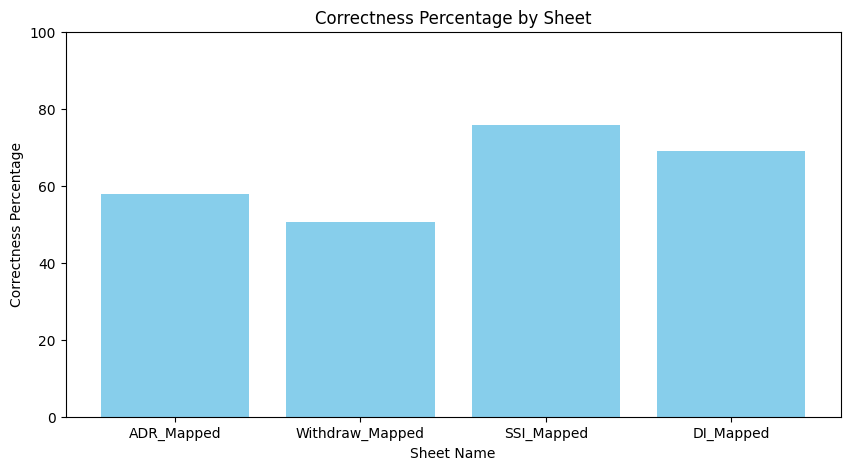

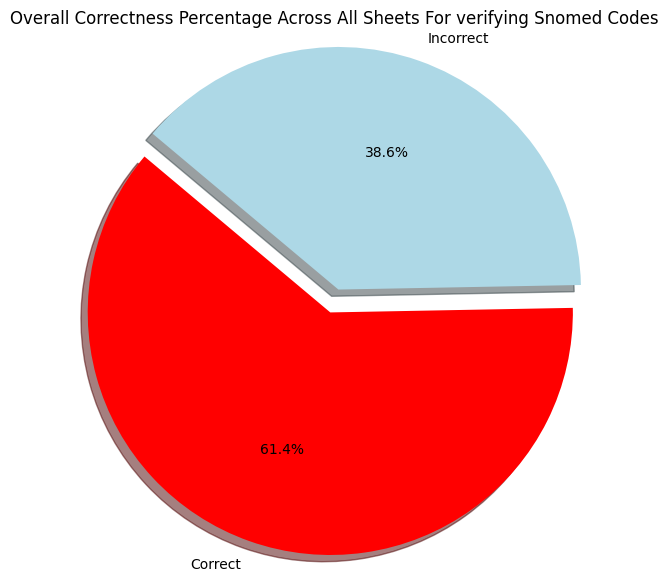

In [ ]:
import matplotlib.pyplot as plt

correctness_dict = {
    'ADR_Mapped': 57.88,
    'Withdraw_Mapped':50.51,
    'SSI_Mapped': 75.64,
    'DI_Mapped': 69.07
}

overall_correctness = 61.41

def visualize_correctness(correctness_dict, overall_correctness):
    # Bar chart for each sheet's correctness
    plt.figure(figsize=(10, 5))
    plt.bar(correctness_dict.keys(), correctness_dict.values(), color='skyblue')
    plt.title('Correctness Percentage by Sheet')
    plt.xlabel('Sheet Name')
    plt.ylabel('Correctness Percentage')
    plt.ylim(0, 100)  # Set y-axis limits to show percentages clearly
    plt.show()

    # Pie chart for overall correctness
    plt.figure(figsize=(7, 7))
    labels = ['Correct', 'Incorrect']
    sizes = [overall_correctness, 100 - overall_correctness]
    colors = ['red', 'lightblue']
    explode = (0.1, 0)  # Only "explode" the first slice (i.e., 'Correct')
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=140)
    plt.title('Overall Correctness Percentage Across All Sheets For verifying Snomed Codes')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

visualize_correctness(correctness_dict, overall_correctness)


Saving PsyTAR_Dataset.xlsx to PsyTAR_Dataset (5).xlsx
Sheet 'License' is empty.
Completeness for read_me:
Unnamed: 0    39.285714
Unnamed: 1    39.285714
Unnamed: 2    82.142857
Unnamed: 3    82.142857
Unnamed: 4    10.714286
Unnamed: 5     7.142857
dtype: float64

Completeness for Sample:
index              100.000000
comment_index      100.000000
comment_id         100.000000
drug_id            100.000000
rating             100.000000
disorder           100.000000
side-effect         98.092031
comment             86.083053
gender              98.877666
age                 98.653199
dosage_duration     99.663300
date               100.000000
category           100.000000
dtype: float64

Completeness for Sentence_Labeling:
id                 99.983361
comment_id         99.983361
drug_id            99.983361
sentence_index     99.983361
sentences          99.966722
ADR                36.089850
WD                  7.304493
EF                 18.103161
INF                 5.623960
SSI   

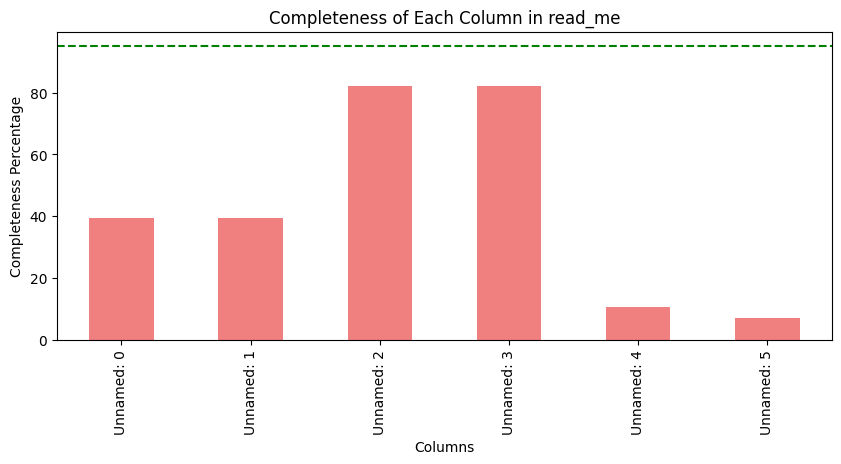

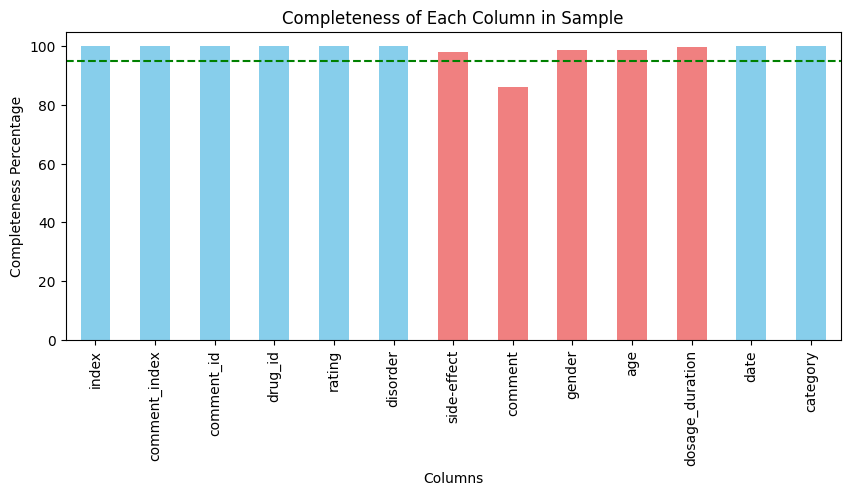

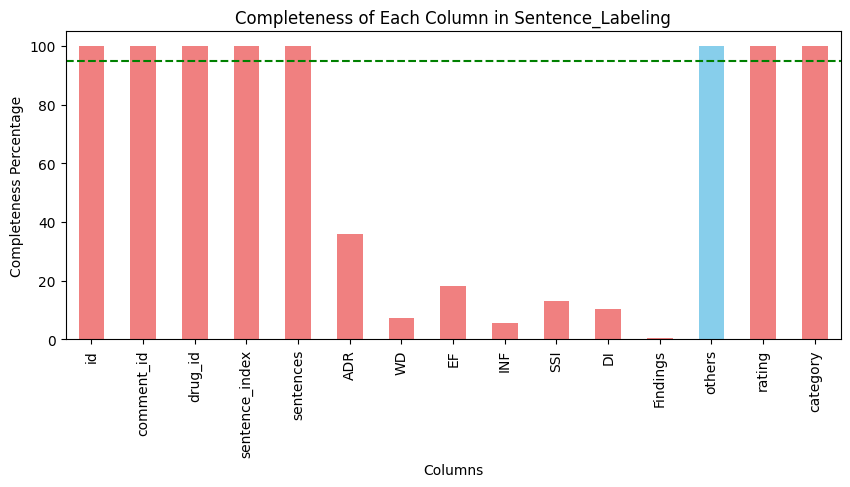

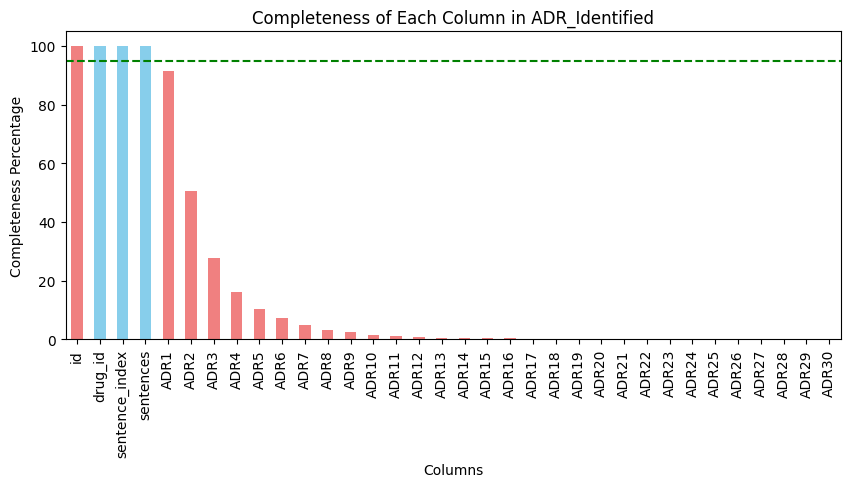

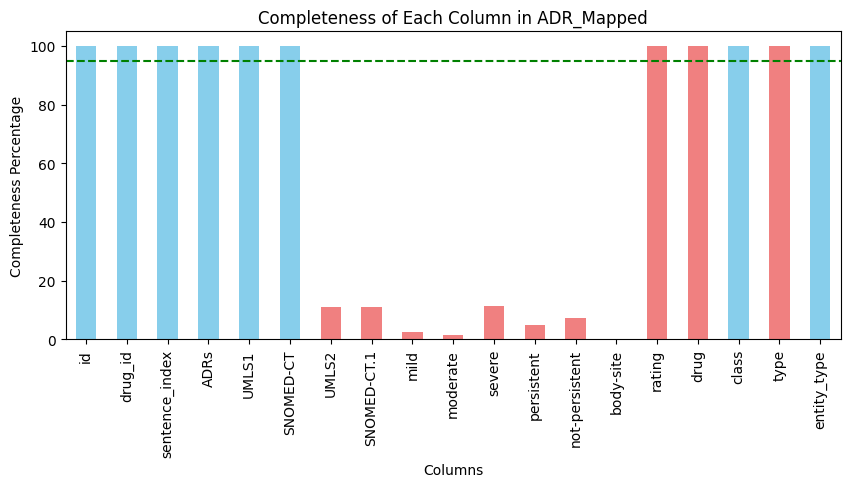

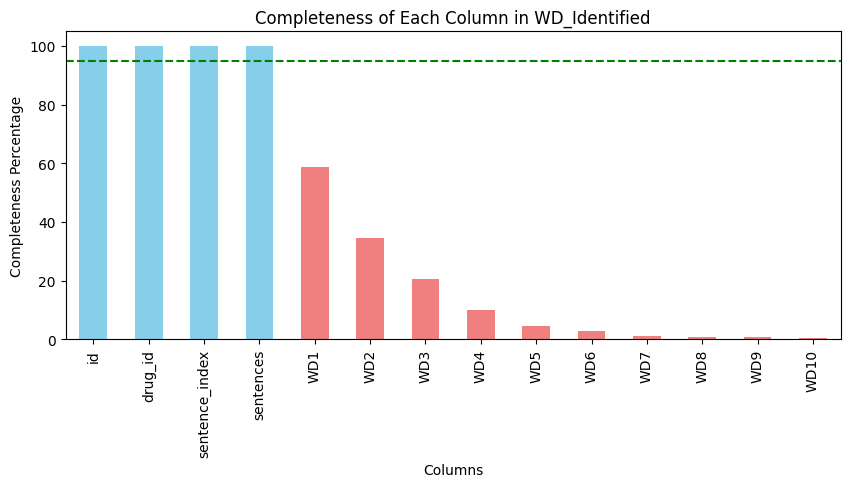

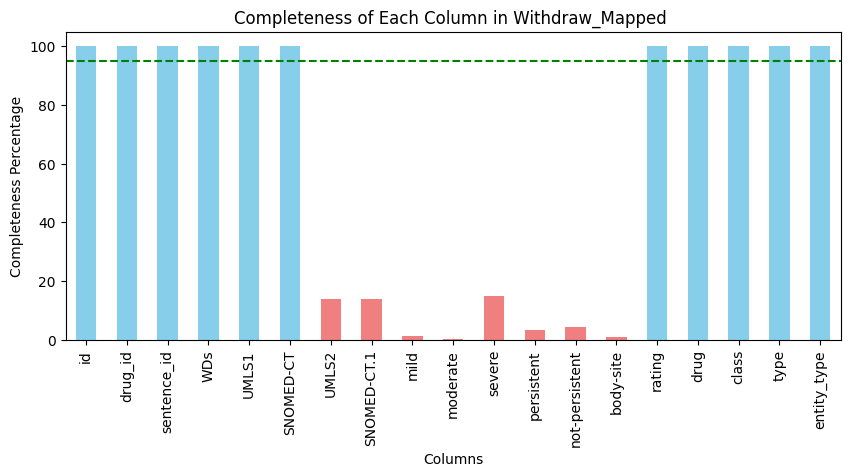

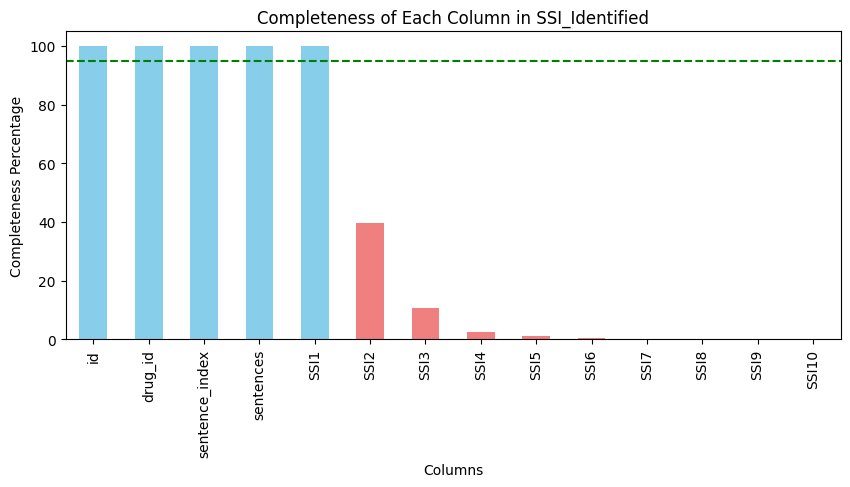

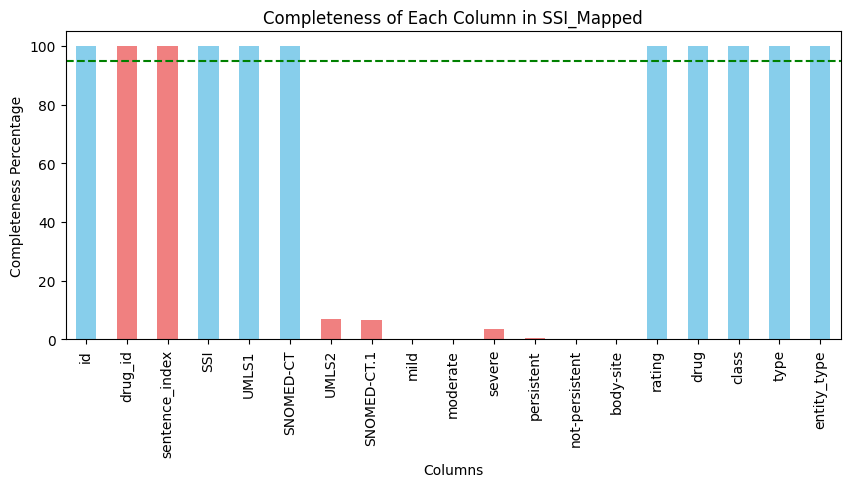

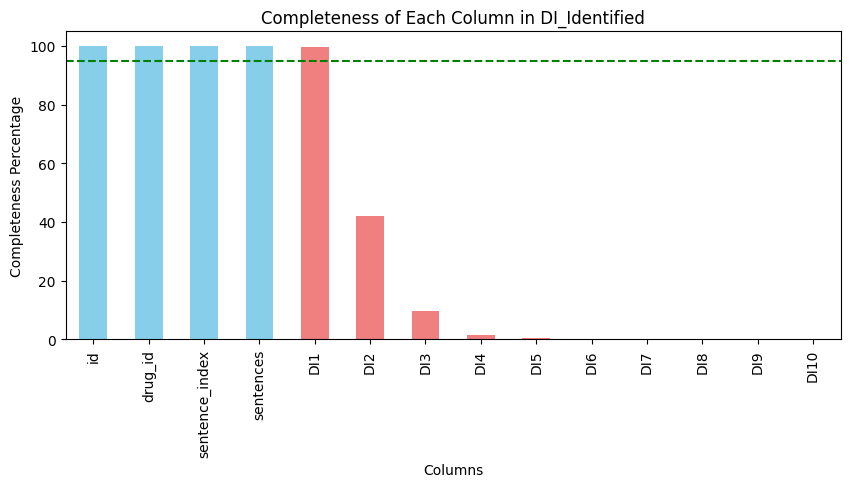

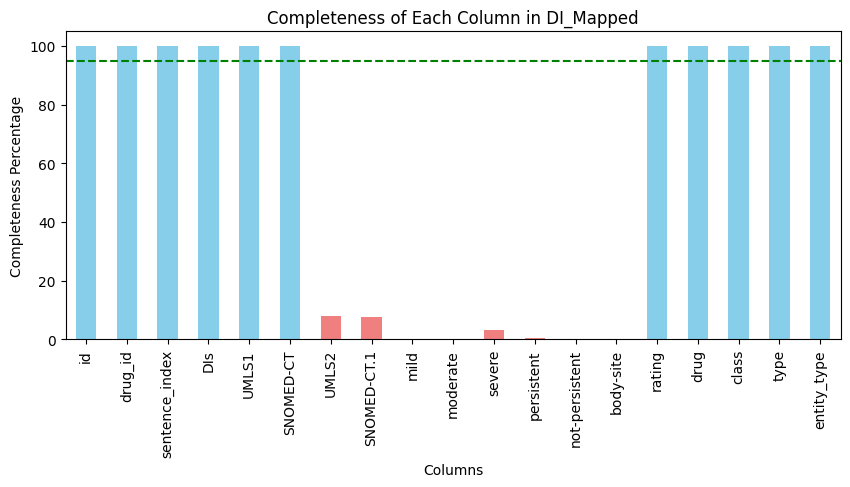

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

def load_data():
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    return pd.read_excel(file_name, sheet_name=None)

def calculate_completeness(df):
    if df.empty:
        return None  # Return None if DataFrame is empty
    total_counts = df.shape[0]
    non_null_counts = df.count()
    completeness = (non_null_counts / total_counts) * 100
    return completeness

def visualize_completeness(completeness_dict):
    for sheet_name, completeness in completeness_dict.items():
        if completeness is not None:  # Check if completeness was calculated
            plt.figure(figsize=(10, 4))  # Consistent figure size
            colors = ['skyblue' if val == 100 else 'lightcoral' for val in completeness]
            completeness.plot(kind='bar', color=colors)
            plt.title(f'Completeness of Each Column in {sheet_name}')
            plt.xlabel('Columns')
            plt.ylabel('Completeness Percentage')
            plt.axhline(y=95, color='green', linestyle='--')  # Optional: Threshold line
            plt.show()
        else:
            print(f"No data to display for {sheet_name}. Sheet may be empty.")


def main():
    sheets = load_data()
    completeness_dict = {}
    for sheet_name, df in sheets.items():
        if not df.empty:  # Check if the DataFrame is not empty
            completeness = calculate_completeness(df)
            if completeness is not None:
                completeness_dict[sheet_name] = completeness
                print(f"Completeness for {sheet_name}:\n{completeness}\n")
            else:
                print(f"Sheet '{sheet_name}' contains no data.")
        else:
            print(f"Sheet '{sheet_name}' is empty.")
    visualize_completeness(completeness_dict)

if __name__ == "__main__":
    main()


Saving PsyTAR_Dataset.xlsx to PsyTAR_Dataset (6).xlsx
Overall completeness of the document: 50.67%


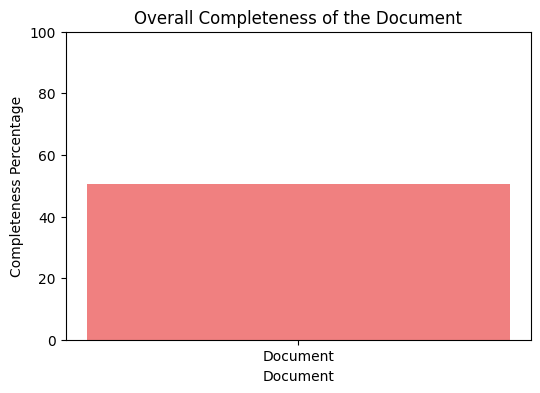

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

def load_data():
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    return pd.read_excel(file_name, sheet_name=None)

def calculate_overall_completeness(df):
    if df.empty:
        return None  # Return None if DataFrame is empty
    total_cells = df.size
    non_null_cells = df.notna().sum().sum()
    overall_completeness = (non_null_cells / total_cells) * 100
    return overall_completeness

def visualize_completeness(overall_completeness):
    plt.figure(figsize=(6, 4))
    plt.bar('Document', overall_completeness, color='skyblue' if overall_completeness == 100 else 'lightcoral')
    plt.title('Overall Completeness of the Document')
    plt.xlabel('Document')
    plt.ylabel('Completeness Percentage')
    plt.ylim([0, 100])
    plt.show()

def main():
    sheets = load_data()
    total_non_null_cells = 0
    total_cells = 0

    for sheet_name, df in sheets.items():
        if not df.empty:
            non_null_cells = df.notna().sum().sum()
            total_cells += df.size
            total_non_null_cells += non_null_cells

    if total_cells > 0:
        overall_completeness = (total_non_null_cells / total_cells) * 100
        print(f"Overall completeness of the document: {overall_completeness:.2f}%")
        visualize_completeness(overall_completeness)
    else:
        print("The document is empty or contains no data.")

if __name__ == "__main__":
    main()


Saving PsyTAR_Dataset.xlsx to PsyTAR_Dataset (7).xlsx
Sheet 'License' is empty.
Comprehensiveness for read_me:
Unnamed: 0    39.285714
Unnamed: 1    39.285714
Unnamed: 2    82.142857
Unnamed: 3    82.142857
Unnamed: 4    10.714286
Unnamed: 5     7.142857
dtype: float64

Comprehensiveness for Sample:
index              100.000000
comment_index      100.000000
comment_id         100.000000
drug_id            100.000000
rating             100.000000
disorder           100.000000
side-effect         98.092031
comment             86.083053
gender              98.877666
age                 98.653199
dosage_duration     99.663300
date               100.000000
category           100.000000
dtype: float64

Comprehensiveness for Sentence_Labeling:
id                 99.983361
comment_id         99.983361
drug_id            99.983361
sentence_index     99.983361
sentences          99.966722
ADR                36.089850
WD                  7.304493
EF                 18.103161
INF                 

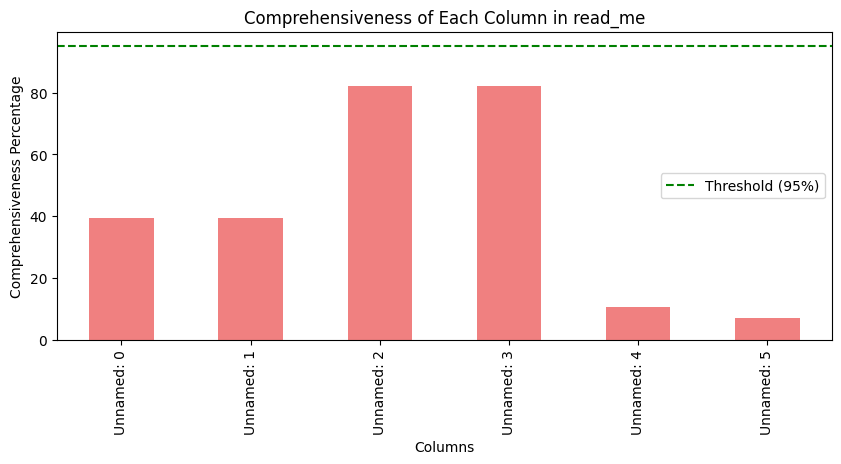

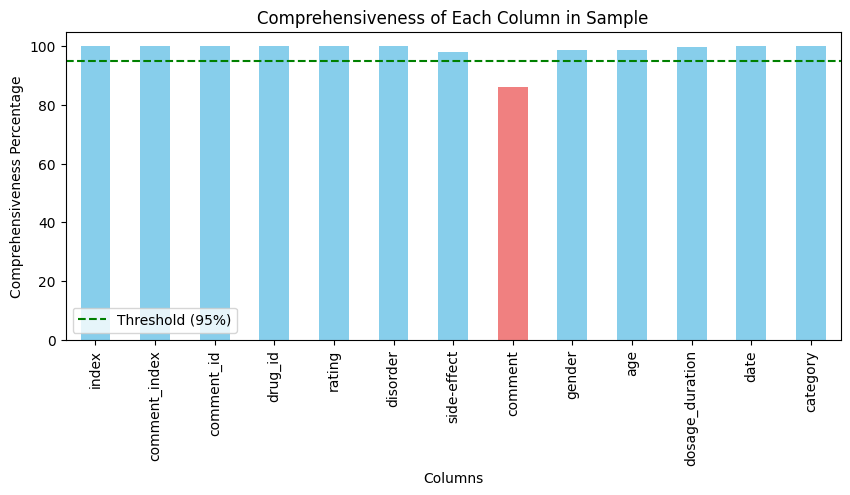

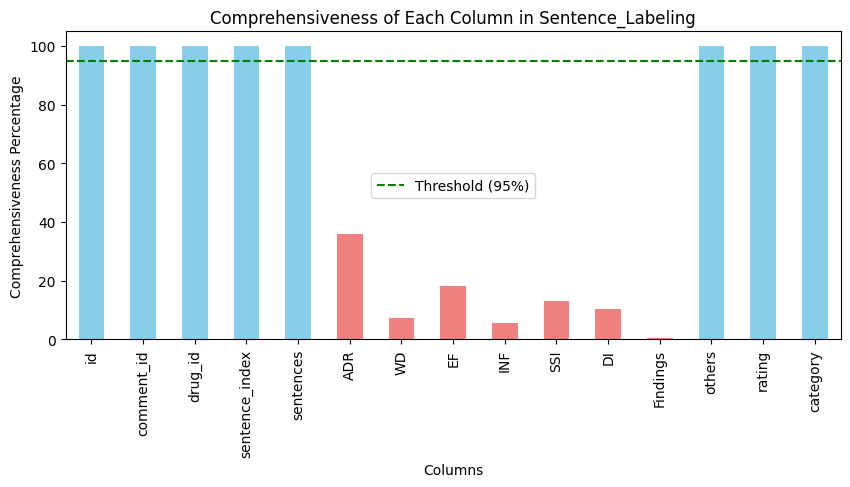

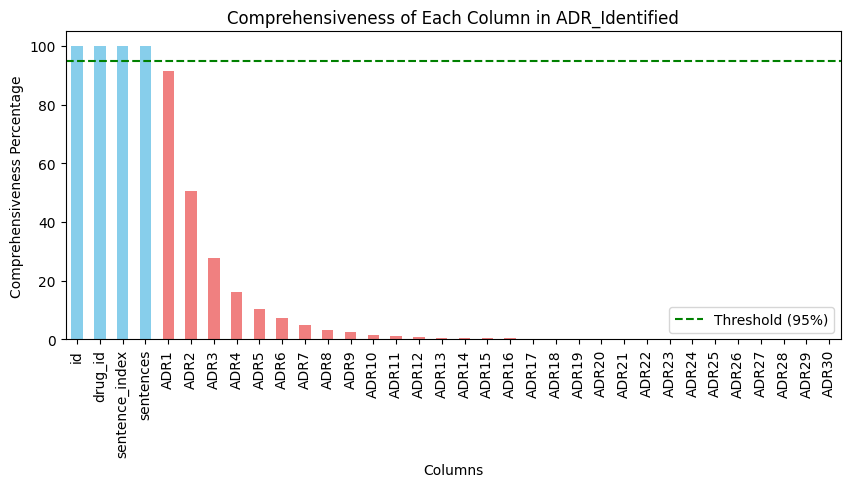

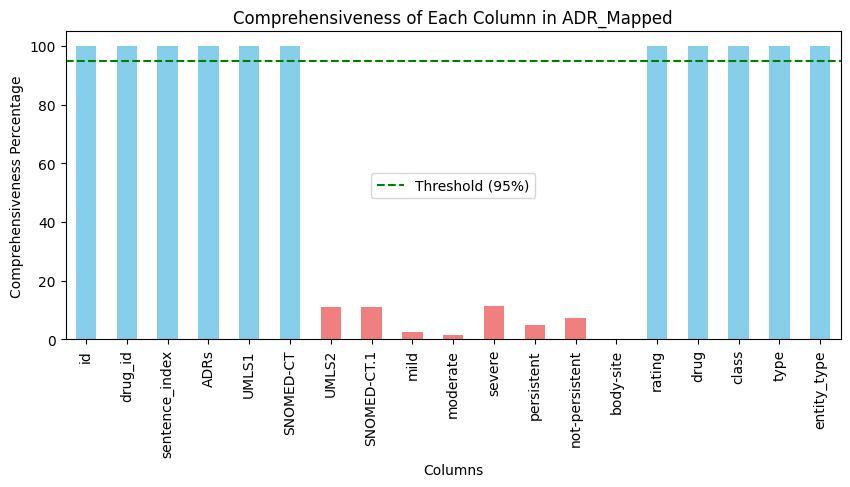

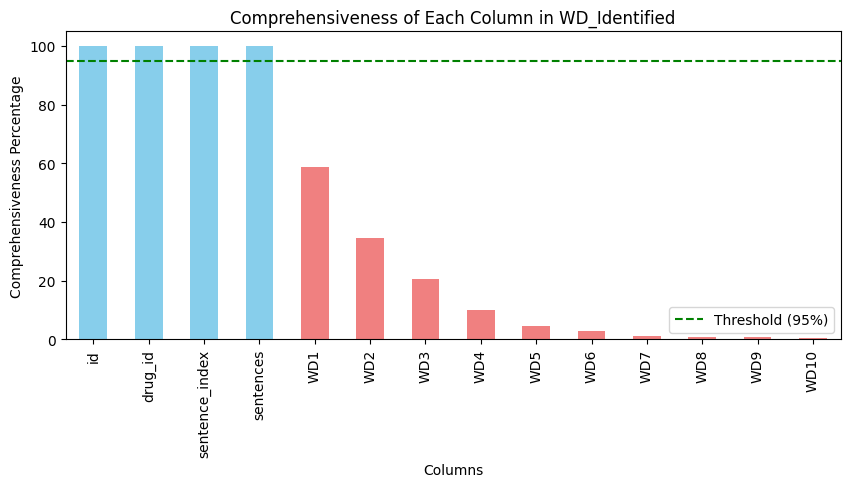

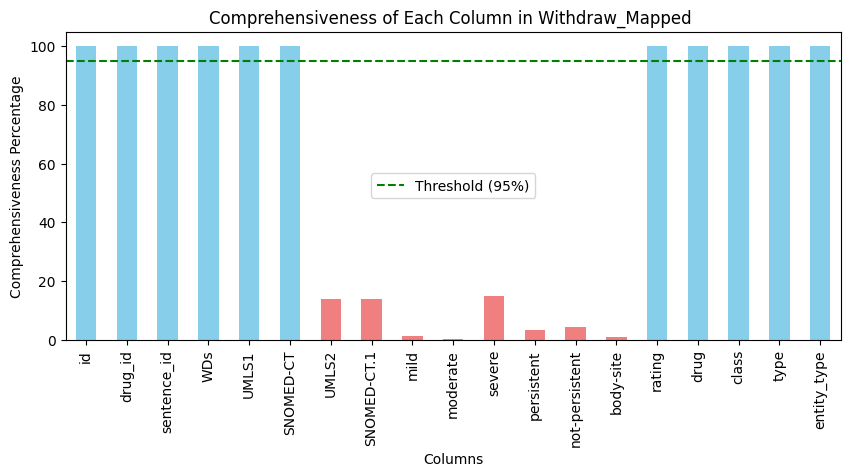

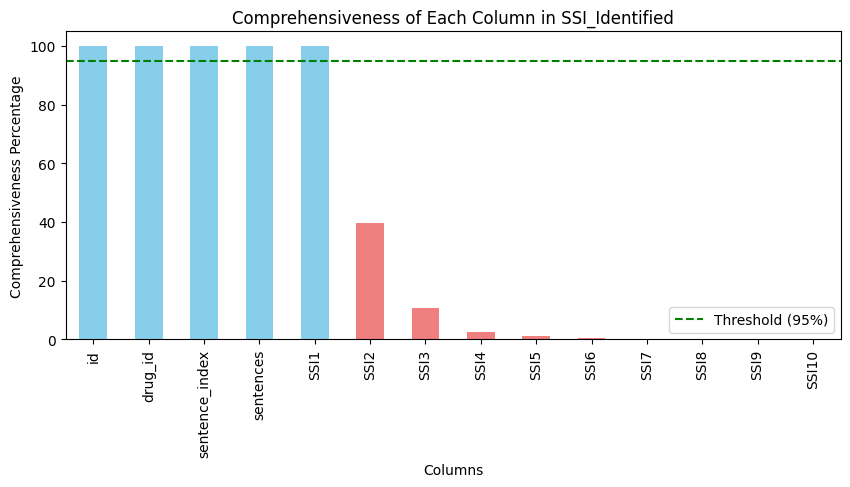

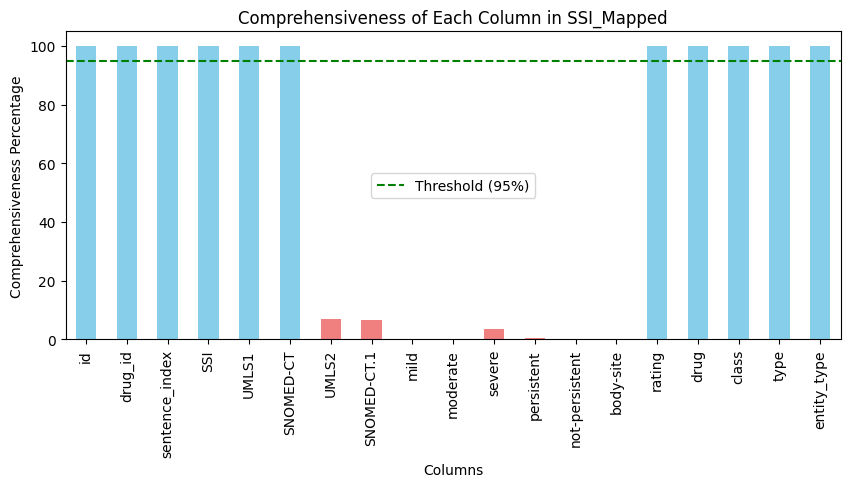

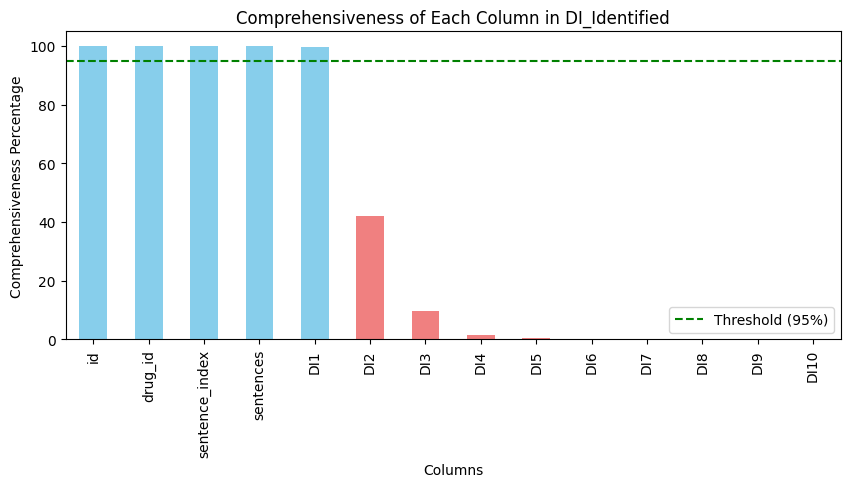

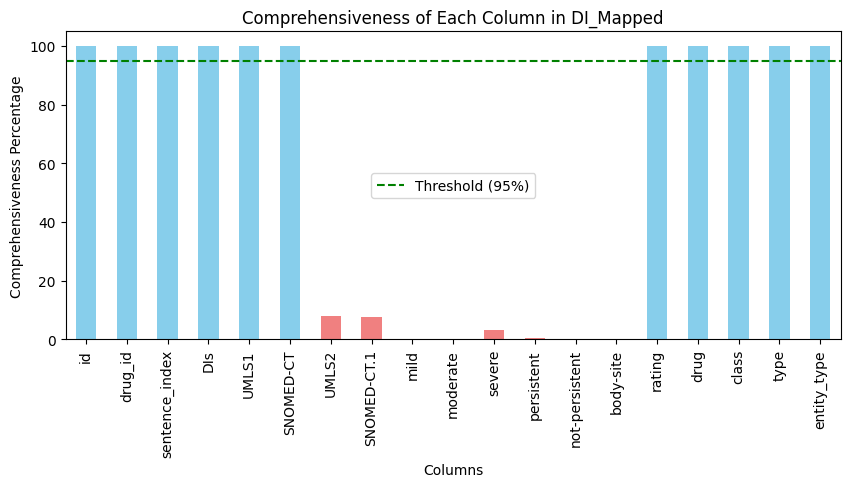

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Function to load the data from an Excel file
def load_data():
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    return pd.read_excel(file_name, sheet_name=None)

# Function to calculate comprehensiveness for each column
def calculate_comprehensiveness(df, comprehensiveness_threshold=95):
    if df.empty:
        return None  # Return None if DataFrame is empty

    total_counts = df.shape[0]
    non_null_counts = df.count()
    comprehensiveness = (non_null_counts / total_counts) * 100

    # Evaluate whether each column meets the comprehensiveness threshold
    comprehensive_columns = comprehensiveness >= comprehensiveness_threshold

    return comprehensiveness, comprehensive_columns

# Function to visualize comprehensiveness
def visualize_comprehensiveness(comprehensiveness_dict):
    for sheet_name, (comprehensiveness, comprehensive_columns) in comprehensiveness_dict.items():
        if comprehensiveness is not None:  # Check if comprehensiveness was calculated
            plt.figure(figsize=(10, 4))
            colors = ['skyblue' if is_comprehensive else 'lightcoral'
                      for is_comprehensive in comprehensive_columns]
            comprehensiveness.plot(kind='bar', color=colors)
            plt.title(f'Comprehensiveness of Each Column in {sheet_name}')
            plt.xlabel('Columns')
            plt.ylabel('Comprehensiveness Percentage')
            plt.axhline(y=95, color='green', linestyle='--', label='Threshold (95%)')  # Threshold line
            plt.legend()
            plt.show()
        else:
            print(f"No data to display for {sheet_name}. Sheet may be empty.")

# Main function to calculate and visualize comprehensiveness
def main():
    sheets = load_data()
    comprehensiveness_dict = {}

    for sheet_name, df in sheets.items():
        if not df.empty:  # Check if the DataFrame is not empty
            comprehensiveness, comprehensive_columns = calculate_comprehensiveness(df)
            if comprehensiveness is not None:
                comprehensiveness_dict[sheet_name] = (comprehensiveness, comprehensive_columns)
                print(f"Comprehensiveness for {sheet_name}:\n{comprehensiveness}\n")
            else:
                print(f"Sheet '{sheet_name}' contains no data.")
        else:
            print(f"Sheet '{sheet_name}' is empty.")

    visualize_comprehensiveness(comprehensiveness_dict)

if __name__ == "__main__":
    main()
